In [72]:
import pandas as pd
import os
import re
from gensim import models
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk.data
import logging
import numpy as np  # Make sure that numpy is imported
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
import re
import nltk
import time
np.seterr(divide='ignore', invalid='ignore')
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd
import numpy as np
import random
import scipy.spatial.distance as distance
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from scipy.sparse import csr_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import ShuffleSplit
from sklearn.cluster import KMeans

In [73]:
class KaggleWord2VecUtility(object):
    """KaggleWord2VecUtility is a utility class for processing raw HTML text into segments for further learning"""

    @staticmethod
    def review_to_wordlist( review, remove_stopwords=False ):
        # Function to convert a document to a sequence of words,
        # optionally removing stop words.  Returns a list of words.
        #
        # 1. Remove HTML
        review_text = BeautifulSoup(review).get_text()
        #
        # 2. Remove non-letters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        #
        # 3. Convert words to lower case and split them
        words = review_text.lower().split()
        #
        # 4. Optionally remove stop words (false by default)
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            words = [w for w in words if not w in stops]
        #
        # 5. Return a list of words
        return(words)

    # Define a function to split a review into parsed sentences
    @staticmethod
    def review_to_sentences( review, tokenizer, remove_stopwords=False ):
        # Function to split a review into parsed sentences. Returns a
        # list of sentences, where each sentence is a list of words
        #
        # 1. Use the NLTK tokenizer to split the paragraph into sentences
        raw_sentences = tokenizer.tokenize(review.decode('utf8').strip())
        #
        # 2. Loop over each sentence
        sentences = []
        for raw_sentence in raw_sentences:
            # If a sentence is empty, skip it
            if len(raw_sentence) > 0:
                # Otherwise, call review_to_wordlist to get a list of words
                sentences.append( KaggleWord2VecUtility.review_to_wordlist( raw_sentence, \
                  remove_stopwords ))
        #
        # Return the list of sentences (each sentence is a list of words,
        # so this returns a list of lists
        return sentences

In [74]:
# ****** Define functions to create average word vectors
#

def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    #
    # Index2word is a list that contains the names of the words in
    # the model's vocabulary. Convert it to a set, for speed
    index2word_set = set(model.wv.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    #
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate
    # the average feature vector for each one and return a 2D numpy array
    #
    # Initialize a counter
    counter = 0.
    #
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    #
    # Loop through the reviews
    for review in reviews:
       #
       # Print a status message every 1000th review
       #if counter%1000. == 0.:
           #print "Review %d of %d" % (counter, len(reviews))
       #
       # Call the function (defined above) that makes average feature vectors
       reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, \
           num_features)
       #
       # Increment the counter
       counter = counter + 1.
    return reviewFeatureVecs


def getCleanReviews(reviews):
    clean_reviews = []
    for review in reviews["review"]:
        clean_reviews.append( KaggleWord2VecUtility.review_to_wordlist( review, remove_stopwords=True ))
    return clean_reviews

In [75]:
#turning off logging for INFO level messages, there are too many
import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.FATAL)
logging.root.level = logging.FATAL  # ipython sometimes messes up the logging setup; restore

In [77]:
# Read data from files
train = pd.read_csv('./data/labeledTrainData.tsv', header=0, delimiter="\t", quoting=3 )
test = pd.read_csv('./data/testData.tsv', header=0, delimiter="\t", quoting=3 )
unlabeled_train = pd.read_csv('./data/unlabeledTrainData.tsv', header=0,  delimiter="\t", quoting=3 )

# Verify the number of reviews that were read (100,000 in total)
print ("Read %d labeled train reviews, %d labeled test reviews, " \
 "and %d unlabeled reviews\n" % (train["review"].size,
 test["review"].size, unlabeled_train["review"].size ))

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews



In [78]:
# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')


# ****** Split the labeled and unlabeled training sets into clean sentences
#
sentences = []  # Initialize an empty list of sentences

print ("Parsing sentences from training set")
for review in train["review"]:
    sentences += KaggleWord2VecUtility.review_to_sentences(review, tokenizer)

print ("Parsing sentences from unlabeled set")
for review in unlabeled_train["review"]:
    sentences += KaggleWord2VecUtility.review_to_sentences(review, tokenizer)

Parsing sentences from training set
Parsing sentences from unlabeled set


In [3]:
# ****** Set parameters and train the word2vec model
#

# Set values for various parameters
num_features = 100    # Word vector dimensionality=embedding dimension
min_word_count = 40   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 5          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
print ("Training Word2Vec model...")
model = Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling, seed=1)

# If you don't plan to train the model any further, calling
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and
# save the model for later use. You can load it later using Word2Vec.load()
Z1=model.wv.syn0

Training Word2Vec model...


In [80]:
#Getting Google's word2vec model
model_g = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

#filtering the words to keep only the ones that occur in the smaller model
all_google_words=model_g.vocab.keys()
Z2=None
new_vocab_g=[]
all_indices=[]
for i in range(0,len(model_g.vocab)):
    if all_google_words[i] in model.wv.vocab:
        #print all_google_words[i]
        all_indices.append(i)
        if Z2==None:
            Z2=model_g.syn0[i]
            new_vocab_g.append(all_google_words[i])
        else:
            Z2=np.vstack((Z2,model_g.syn0[i]))
            new_vocab_g.append(all_google_words[i])
print (Z2.shape,len(new_vocab_g))

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  del sys.path[0]


((15181, 300), 15181)


**NOTE** Doing K-means clustering on Z1 and Z2 using number of clusters=100 because it gives good clusters for Z1, and average #words per cluster is ~160 (if we use K=10, there would be ~1600 words per cluster on an average)

In [88]:
# Q1 c- Kmeans clustering
from sklearn.cluster import KMeans
# Set "k" =100
# average of ~160 words per cluster since there are 16000 words approximately
num_clusters = 100  #change  word_vectors.shape[0] / 20

# Initalize a k-means object and use it to extract centroids
print "Running K means on Z1"
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( Z1 )

# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number
word_centroid_map = dict(zip( model.wv.index2word, idx ))

# Print the closest 20 words to the centroid
#for each cluster get the distance of each point to the cluster center
print "printing 20 closest words to each cluster center for Z1...\n"
for c in range(0,10):
    dist=kmeans_clustering.transform(Z1)[:,c]
    indices=np.argpartition(dist,20) #since we want only the 20 closest words
    sorted_indices=np.sort(indices[0:20])
    #print sorted_indices
    print "Cluster",c," : ",np.array(model.wv.index2word)[sorted_indices]

 Running K means on Z1
printing 20 closest words to each cluster center for Z1...

Cluster 0  :  [u'repressed' u'controlling' u'suicidal' u'confronting' u'sacrificing'
 u'reckless' u'wayward' u'abuses' u'abusing' u'ada' u'impotent'
 u'embittered' u'brutish' u'illicit' u'injecting' u'heartbroken'
 u'uncaring' u'adopting' u'mistreated' u'ruthlessly']
Cluster 1  :  [u'larry' u'jay' u'lawrence' u'phil' u'ernest' u'doug' u'freddie' u'sid'
 u'nolan' u'bauer' u'randall' u'nash' u'mcdonald' u'sr' u'lau' u'starr'
 u'maguire' u'brodie' u'mckay' u'cummings']
Cluster 2  :  [u'hypocrisy' u'hysteria' u'alienation' u'alcoholism' u'patriotism'
 u'societal' u'depravity' u'repression' u'spirituality' u'intolerance'
 u'aggression' u'bigotry' u'sadism' u'misogyny' u'persecution'
 u'degradation' u'harassment' u'obsessions' u'voyeurism' u'conformity']
Cluster 3  :  [u'manipulative' u'neurotic' u'smug' u'unstable' u'overbearing'
 u'conflicted' u'insecure' u'bitchy' u'stubborn' u'perpetually'
 u'effeminate' u

In [95]:
print ("Running K means on Z2")
kmeans_clustering_g = KMeans( n_clusters = num_clusters )
idx_g = kmeans_clustering_g.fit_predict( Z2 )

# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number
word_centroid_map_g = dict(zip( new_vocab_g, idx_g ))

# Print the closest 20 words to the centroid
#for each cluster get the distance of each point to the cluster center
print ("printing 20 closest words to the first 10 cluster centers for Z2...\n")
for c in range(0,10):
    dist=kmeans_clustering_g.transform(Z2)[:,c]
    indices=np.argpartition(dist,20) #since we want only the 20 closest words
    sorted_indices=np.sort(indices[0:20])
    #print sorted_indices
    print ("Cluster",c," : ",np.array(new_vocab_g)[sorted_indices])

Running K means on Z2
printing 20 closest words to the first 10 cluster centers for Z2...

Cluster 0  :  [u'sadness' u'butterfly' u'mona' u'arriving' u'carbon' u'listener'
 u'hampered' u'touched' u'dates' u'verge' u'wolf' u'abound' u'gracefully'
 u'sees' u'sludge' u'na' u'consultant' u'believers' u'sweetheart'
 u'bubblegum']
Cluster 1  :  [u'strategy' u'motives' u'quo' u'raunchy' u'balloon' u'spectrum' u'watcher'
 u'vancouver' u'singer' u'na' u'tug' u'flows' u'sleepwalking' u'believers'
 u'nifty' u'thumbs' u'start' u'seamlessly' u'justify' u'femme']
Cluster 2  :  [u'unfolding' u'plumber' u'trio' u'flooded' u'pam' u'sordid' u'vivek'
 u'cloying' u'pacifist' u'cough' u'syndicate' u'rewritten' u'prequels'
 u'floor' u'corners' u'risky' u'arranges' u'reversed' u'tip' u'straight']
Cluster 3  :  [u'socially' u'tibet' u'awake' u'jan' u'reclaim' u'docu' u'happening'
 u'consultant' u'injects' u'dangling' u'tightrope' u'elitist' u'badass'
 u'sylvia' u'hinges' u'hacker' u'janice' u'bach' u'subconsc

In [89]:
#clean train and test reviews
print ("Cleaning training reviews")
clean_train_reviews = []
for review in train["review"]:
    clean_train_reviews.append( KaggleWord2VecUtility.review_to_wordlist( review, \
        remove_stopwords=True ))

print ("Cleaning test reviews")
clean_test_reviews = []
for review in test["review"]:
    clean_test_reviews.append( KaggleWord2VecUtility.review_to_wordlist( review, \
        remove_stopwords=True ))

print ("Done")

Cleaning training reviews
Cleaning test reviews
Done


In [90]:
# Q1 Part d- Transform the training set, test set reviews into bags of centroids

# Define a function to create bags of centroids
#

def create_bag_of_centroids( wordlist, word_centroid_map ):
    #
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max( word_centroid_map.values() ) + 1
    #
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    #
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count
    # by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    #
    # Return the "bag of centroids"
    return bag_of_centroids

#although we do the lda modeling for unlabelled and labelled training set
# we train the random forest only on the labelled train set, so take just that many

print ("creating X1, X1_test")
#create X1, X1_test
#  Pre-allocate an array for the training set bags of centroids (for speed)
X1 = np.zeros( (train["review"].size, num_clusters), dtype="float32" )

counter = 0
for review in clean_train_reviews[:train["review"].size]:
    X1[counter] = create_bag_of_centroids( review, word_centroid_map )
    counter += 1

# Repeat for test reviews
X1_test = np.zeros(( test["review"].size, num_clusters), dtype="float32" )

counter = 0
for review in clean_test_reviews:
    X1_test[counter] = create_bag_of_centroids( review, word_centroid_map )
    counter += 1

print ("creating X2, X2_test")
#create X2, X2_test
#  Pre-allocate an array for the training set bags of centroids (for speed)
X2 = np.zeros( (train["review"].size, num_clusters), dtype="float32" )

counter = 0
for review in clean_train_reviews[:train["review"].size]:
    X2[counter] = create_bag_of_centroids( review, word_centroid_map_g )
    counter += 1

# Repeat for test reviews
X2_test = np.zeros(( test["review"].size, num_clusters), dtype="float32" )

counter = 0
for review in clean_test_reviews:
    X2_test[counter] = create_bag_of_centroids( review, word_centroid_map_g )
    counter += 1

print ("Done")

creating X1, X1_test
creating X2, X2_test
Done


In [99]:
#Q2- Create LDA topic models

#num_topics = 10

#setting logging to only fatal, it creates too many messages otherwise
import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.FATAL)
logging.root.level = logging.FATAL

from gensim import corpora
#for training data
dictionary_train = corpora.Dictionary(sentences)
corpus_train = [dictionary_train.doc2bow(text) for text in clean_train_reviews]
ldamodel_10 = models.ldamodel.LdaModel(corpus_train, num_topics=10, id2word = dictionary_train)

#featurize the reviews- train and test set
X3_orig=ldamodel_10[corpus_train]

#create the test set corpus
dictionary_test = corpora.Dictionary(clean_test_reviews)
corpus_test = [dictionary_train.doc2bow(text) for text in clean_test_reviews]
X3_test_orig=ldamodel_10[corpus_test]

In [100]:
#Q2 b- Create LDA topic models, num_topics = 20
ldamodel_20 = models.ldamodel.LdaModel(corpus_train, num_topics=20, id2word = dictionary_train)

#featurize the reviews- train and test set
X4_orig=ldamodel_20[corpus_train]
#for the test set
X4_test_orig=ldamodel_20[corpus_test]

In [101]:
#convert X3, X4 (train and test) to np array

X3=np.zeros((train.shape[0],10))
for i in range(0,train.shape[0]):
    row=X3_orig[i]
    for [j,val] in row:
        X3[i,j]=val
X3_test=np.zeros((test.shape[0],10))
for i in range(0,test.shape[0]):
    row=X3_test_orig[i]
    for [j,val] in row:
        X3_test[i,j]=val

X4=np.zeros((train.shape[0],20))
for i in range(0,train.shape[0]):
    row=X4_orig[i]
    for [j,val] in row:
        X4[i,j]=val

X4_test=np.zeros((test.shape[0],20))
for i in range(0,test.shape[0]):
    row=X4_test_orig[i]
    for [j,val] in row:
        X4_test[i,j]=val
print ("Done")

Done


In [102]:
#Printing top 10 words with highest probabilities for each topic

#LDA model with num_topics=10
print ("For Model ldamodel_10(num_topics=10) \n")
print(ldamodel_10.print_topics(num_topics=10, num_words=10))   

#LDA model with num_topics=20
print ("\nFor Model ldamodel_20(num_topics=20) \n")
print(ldamodel_20.print_topics(num_topics=20, num_words=10))

For Model ldamodel_10(num_topics=10) 

[(0, u'0.015*"film" + 0.006*"one" + 0.004*"world" + 0.003*"people" + 0.003*"also" + 0.003*"time" + 0.003*"story" + 0.003*"life" + 0.003*"us" + 0.003*"like"'), (1, u'0.005*"movie" + 0.004*"one" + 0.004*"gandhi" + 0.003*"like" + 0.003*"emma" + 0.003*"good" + 0.003*"moore" + 0.003*"rock" + 0.002*"movies" + 0.002*"bollywood"'), (2, u'0.007*"film" + 0.005*"one" + 0.003*"like" + 0.003*"jerry" + 0.003*"horror" + 0.003*"movie" + 0.003*"house" + 0.003*"kelly" + 0.003*"man" + 0.003*"story"'), (3, u'0.007*"one" + 0.007*"movie" + 0.006*"film" + 0.004*"like" + 0.004*"life" + 0.004*"get" + 0.003*"people" + 0.003*"way" + 0.003*"man" + 0.003*"would"'), (4, u'0.007*"one" + 0.005*"show" + 0.004*"new" + 0.003*"film" + 0.003*"first" + 0.003*"man" + 0.003*"time" + 0.003*"tarzan" + 0.003*"police" + 0.002*"even"'), (5, u'0.035*"film" + 0.009*"one" + 0.008*"films" + 0.006*"story" + 0.005*"much" + 0.005*"well" + 0.004*"movie" + 0.004*"like" + 0.004*"first" + 0.004*"book"'

In [103]:
#FROMcv for tuning number of trees

def tune_RF(X_train, y_train):
    scores_trees=[]
    trees_list=[10,50,100,200,300,500]
    random.seed(0)

    for i in range(0,len(trees_list)):
        #generating a random value for the exponent of 10.
        #This gives us a uniform random value generation over 1e-4 to 1e+4
        estimator = RandomForestClassifier(n_estimators = trees_list[i])
        train_sizes, train_scores, test_scores = learning_curve(estimator, X_train, y_train, cv=5, scoring='roc_auc')
        scores_trees.append(np.mean(test_scores))

    #keep the value of C giving maximum roc_auc score
    best_num= trees_list[np.argmax(scores_trees)]
    print ("Best num of trees= ",best_num, "Best score= ",np.max(scores_trees))
    return best_num, np.max(scores_trees)

Q3- Tuning number of trees by cross validation for X1,X2,X3,X4

In [118]:
# Fit a random forest and extract predictions for X1
# splitting into 80/20- train/test set
XRF1_train, XRF1_test, YRF1_train, YRF1_test = train_test_split(X1, np.array(train['sentiment']), test_size = 0.2, random_state = 0)
#finding best number of trees
XRF1_num, XRF1_AUC=tune_RF(XRF1_train, YRF1_train)
print ("X1 Random Forest trained")

# Fit a random forest and extract predictions for X2
# splitting into 80/20- train/test set
XRF2_train, XRF2_test, YRF2_train, YRF2_test = train_test_split(X2, np.array(train['sentiment']), test_size = 0.2, random_state = 0)
#finding best number of trees
XRF2_num, XRF2_AUC=tune_RF(XRF2_train, YRF2_train)
print ("X2 Random Forest trained")

# Fit a random forest and extract predictions for X3
# splitting into 80/20- train/test set
XRF3_train, XRF3_test, YRF3_train, YRF3_test = train_test_split(X3, np.array(train['sentiment']), test_size = 0.2, random_state = 0)
#finding best number of trees
XRF3_num, XRF3_AUC=tune_RF(XRF3_train, YRF3_train)
print ("X3 Random Forest trained")

# Fit a random forest and extract predictions for X4
# splitting into 80/20- train/test set
XRF4_train, XRF4_test, YRF4_train, YRF4_test = train_test_split(X4, np.array(train['sentiment']),\
                                                                test_size = 0.2, random_state = 0)
#finding best number of trees
XRF4_num, XRF4_AUC=tune_RF(XRF4_train, YRF4_train)
print ("X4 Random Forest trained")

('Best num of trees= ', 500, 'Best score= ', 0.871304915422441)
X1 Random Forest trained

('Best num of trees= ', 500, 'Best score= ', 0.6806117398043239)
X2 Random Forest trained

('Best num of trees= ', 500, 'Best score= ', 0.7794499715670181)
X3 Random Forest trained

('Best num of trees= ', 500, 'Best score= ', 0.8343359782204781)
X4 Random Forest trained



Retrain on 80% data with best number of trees and plot ROC

In [7]:
X1_estimator = RandomForestClassifier(n_estimators = XRF1_num).fit(XRF1_train,YRF1_train)
#ROC
predY1=X1_estimator.predict_proba(XRF1_test)
fpr1, tpr1, thresholds = roc_curve(YRF1_test,predY1[:,1])
roc_auc1=auc(fpr1,tpr1)
print ("ROC area X1 ",roc_auc1)

# Retrain the classifier on the 80% train data for X2
X2_estimator = RandomForestClassifier(n_estimators = XRF2_num).fit(XRF2_train,YRF2_train)
#ROC
predY2=X2_estimator.predict_proba(XRF2_test)
fpr2, tpr2, thresholds = roc_curve(YRF2_test,predY2[:,1])
roc_auc2=auc(fpr2,tpr2)
print ("ROC area X2 ",roc_auc2)

# Retrain the classifier on the 80% train data for X3
X3_estimator = RandomForestClassifier(n_estimators = XRF3_num).fit(XRF3_train,YRF3_train)
#ROC
predY3=X3_estimator.predict_proba(XRF3_test)
fpr3, tpr3, thresholds = roc_curve(YRF3_test,predY3[:,1])
roc_auc3=auc(fpr3,tpr3)
print ("ROC area X3 ",roc_auc3)

# Retrain the classifier on the 80% train data for X4

X4_estimator = RandomForestClassifier(n_estimators = XRF4_num).fit(XRF4_train,YRF4_train)
#ROC
predY4=X4_estimator.predict_proba(XRF4_test)
fpr4, tpr4, thresholds = roc_curve(YRF4_test,predY4[:,1])
roc_auc4=auc(fpr4,tpr4)
print ("ROC area X4 ",roc_auc4)

#plot ROC curves
plt.title('ROC curves %0.2f')
plt.plot(fpr1, tpr1,'r:')
plt.plot(fpr2, tpr2,'b-.')
plt.plot(fpr3,tpr3,'m--')
plt.plot(fpr4,tpr4,'g' ,lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['X1:'+str(round(roc_auc1,3)), 'X2:'+str(round(roc_auc2,3)),
            'X3:'+str(round(roc_auc3,3)), 'X4:'+str(round(roc_auc4,3))], loc='best')
plt.savefig('ROC.png')

('ROC area X1 ', 0.8780377598397873)


('ROC area X2 ', 0.6957838537598501)


('ROC area X3 ', 0.7936939473367461)


('ROC area X4 ', 0.841195138175737)


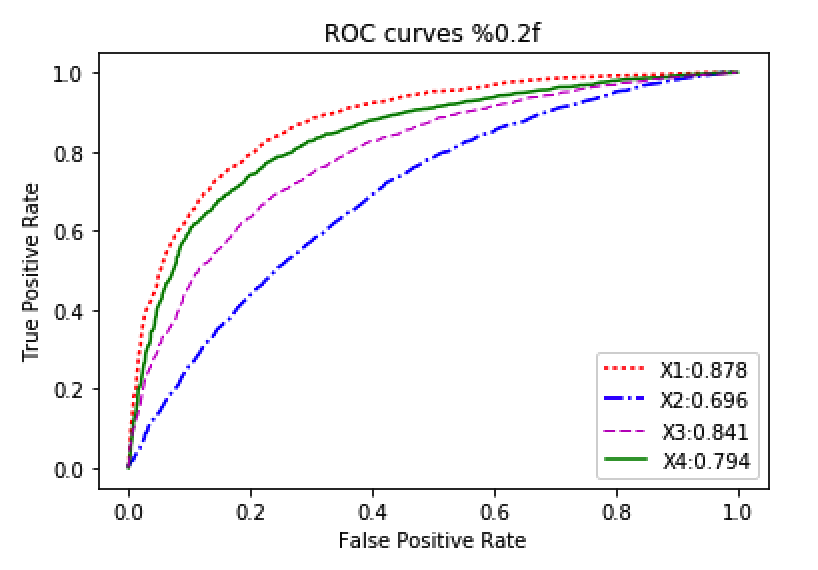

In [6]:
#saved the ROC plot, so loading it here 
from IPython.display import Image
Image(filename='ROC.png')

**NOTE** The values of ROC-AUC do vary with each run possibly because of the random train-test split

In [110]:
#predict output for test set using X1,X2,X3,X4 and store

result = X1_estimator.predict(X1_test)
# Write the test results
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv( "Output_X1.csv", index=False, quoting=3 )

result = X2_estimator.predict(X2_test)
# Write the test results
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv( "Output_X2.csv", index=False, quoting=3 )

result = X3_estimator.predict(X3_test)
# Write the test results
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv( "Output_X3.csv", index=False, quoting=3 )

result = X4_estimator.predict(X4_test)
# Write the test results
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv( "Output_X4.csv", index=False, quoting=3 )

print ("Done")

Done


Kaggle Results (Reporting best accuracy for each X1,X2,X3,X4)

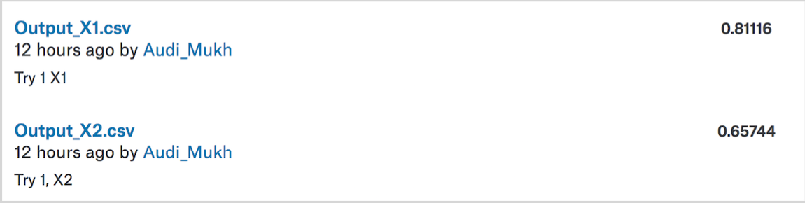

In [122]:
from IPython.display import Image
Image(filename='Kaggle1.png')

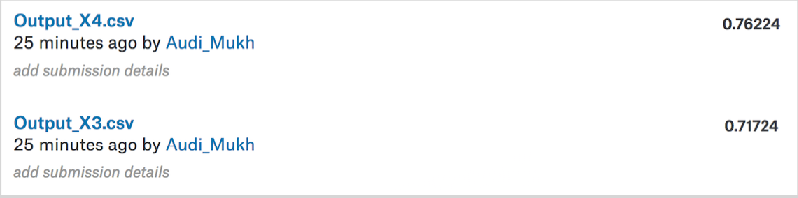

In [126]:
Image(filename='Kaggle2.png')

Q3 Part c

Among the 4 methods used here, the best performance is for the word2vec model we created with context=5, embedding dimension=100, min_words=40 (X1). 

The ROC-AUC for X1 is 87.8% which is comparable to the Bag-of-words model using tf-idf(88.5%). But the bag of words model does better for the Kaggle output prediction getting about 88%. Here Kaggle score is about 81%. 

To increase the efficacy:

1. For the word2vec model that we created in Q1 Part a, we can increase the number of clusters(already did here. I made #clusters=100). That increased the ROC-AUC and the Kaggle score because the features are better represented for more clusters. Since there are about 16000 words, 100 clusters seemed like a good choice.

2. a) For the LDA models, increasing the number of topics should improve the efficacy of the LDA model. 
   b) Also using the unlabelled and labelled training data works better than using just the labelled data for the LDA models(done here).

3. a) Currently the cross validation is to find a good number of trees for the Random forests from the values [10,50,100,200,300,500]. We can use more fine grained values for the number of trees. 
   b) Also we can use cross validation to tune for min_samples_leaf(minimum number of samples required to be at a leaf node) and min_samples_split(minimum number of samples required to split an internal node)